In [2]:
import numpy as np
from keras.engine.keras_tensor import KerasTensor
from tensorflow.keras.models import Model, load_model
from typing import List, Optional
from tensorflow import GradientTape, reduce_mean
from utils.audio_tools import create_audio_player
import tensorflow as tf
from matplotlib import pyplot as plt
from librosa.display import specshow
from librosa import power_to_db
from librosa.feature.inverse import mel_to_audio
from soundfile import write
import utils.constants as consts
from os.path import join
import os
from librosa.feature import melspectrogram
from librosa import tone
from librosa import load
from utils.audio_tools import segment_signal


PATH_TO_MODEL: str = '../runs/models/model_3/epoch-96.pb'
PATH_TO_AUDIO: str = '../media/audio/string_a#.wav'
NUM_LAYERS: int = 44

Get indices of Conv block layers.

In [3]:
def get_model_layers(_model: Model) -> List[Model]:
    """
    :param _model:
    :return:
    """

    layer_output: List[KerasTensor] = [_layer.output for _layer in model.layers[:NUM_LAYERS]]
    activation_model = Model(inputs=model.input, outputs=layer_output)

    return activation_model.layers


def get_conv_layer_indicis(model_layers: List[Model]) -> List[int]:
    """
    :param model_layers:
    :return:
    """

    _conv_block_indicis: List[int] = []

    for i, _layer in enumerate(model_layers):
        if 'conv' in _layer.name:
            _conv_block_indicis.append(i)

    return _conv_block_indicis


def compute_loss(
        _feature_extractor: Model,
        _input_signal: np.ndarray,
        _filter_index: int
) -> float:
    """
    :param _feature_extractor:
    :param _input_signal:
    :param _filter_index:
    :return:
    """

    activation: List[np.ndarray] = _feature_extractor(_input_signal)
    filter_activation = activation[:, :, :, _filter_index]

    return reduce_mean(filter_activation)


@tf.function
def gradient_ascent_step(
        _feature_extractor: Model,
        _signal: np.ndarray,
        _filter_index: int,
        learning_rate: float
) -> np.ndarray:
    """
    :param _feature_extractor:
    :param _signal:
    :param _filter_index:
    :param learning_rate:
    :return:
    """

    with GradientTape() as tape:
        tape.watch(_signal)
        _loss = compute_loss(_feature_extractor, _signal, _filter_index)

    # Compute gradients.
    grads = tape.gradient(_loss, _signal)

    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    _signal += learning_rate * grads

    return _signal


def initialize_image() -> np.ndarray:
    """
    :return:
    """

    noise_mel_spectrogram: np.ndarray = tf.random.uniform((1, 300, 44, 1))

    return noise_mel_spectrogram


def visualize_filter(
        _feature_extractor: Model,
        _filter_index: int,
        learning_rate: float = 10.0,
        iterations: int = 30,
        _signal: Optional[np.ndarray] = None
) -> np.ndarray:
    """
    :param _feature_extractor:
    :param _filter_index:
    :param learning_rate:
    :param iterations:
    :param _signal:
    :return:
    """

    if _signal is None:
        _signal: np.ndarray = initialize_image()

    for _ in range(iterations):
        _signal: np.ndarray = gradient_ascent_step(
            _feature_extractor,
            _signal,
            _filter_index,
            learning_rate
        )

    # Decode the resulting input image.
    _signal = deprocess_image(_signal[0].numpy())

    return _signal


def deprocess_image(_signal: np.ndarray) -> np.ndarray:
    """
    :param _signal:
    :return:
    """

    # Normalize array: center on 0., ensure variance is 0.15.
    _signal -= _signal.mean()
    _signal /= _signal.std() + 1e-5
    _signal *= 0.15

    # Clip to [0, 1].
    _signal = np.clip(_signal, 0, 1)

    return _signal


def convert_signal_into_mel_spectrogram_segments(audio_signal: np.ndarray) -> List[np.ndarray]:
    """
    :param audio_signal:
    :return:
    """

    # Segment signal into 1 second samples
    signal_segments: List[np.ndarray] = segment_signal(audio_signal, window_leap_fraction=1)
    _mel_spec_segments: List[np.ndarray] = []

    # Loop over all segments and encode them into mel spectrograms.
    for _sample in signal_segments:
        encoded_segment: np.ndarray = melspectrogram(
            y=_sample,
            sr=consts.SAMPLE_RATE,
            n_fft=consts.NUM_FFT,
            hop_length=consts.MEL_HOP_LEN,
            n_mels=consts.NUM_MELS,
            win_length=consts.MEL_WINDOW_LEN
        )

        # Reshape mel spectrograms
        encoded_segment = np.array([encoded_segment.reshape(consts.X_SHAPE)])
        _mel_spec_segments.append(encoded_segment)

    return _mel_spec_segments

In [4]:
model: Model = load_model(PATH_TO_MODEL)
layers: List[Model] = get_model_layers(model)
conv_block_indicis: List[int] = get_conv_layer_indicis(layers)

# Set up a model that returns the activation values for our target layer.
layer: Model = model.get_layer(name=layers[conv_block_indicis[0]].name)
feature_extractor: Model = Model(inputs=model.inputs, outputs=layer.output)

2022-04-15 14:18:55.597101: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
PATH_TO_SAMPLE: str = '../long-audio/break_2.wav'
sample: np.ndarray = load(PATH_TO_SAMPLE)[0]

mel_spec_segments: List[np.ndarray] = convert_signal_into_mel_spectrogram_segments(sample)

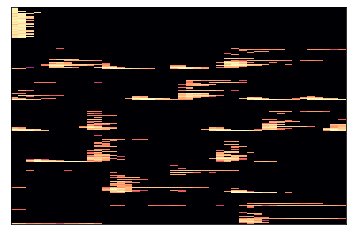

In [9]:
OUTPUT_DIR: str = '../feature_visualization'

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(join(OUTPUT_DIR, 'mel_specs'), exist_ok=True)

def process_sample_through_neuron(neuron_index, _mel_spec_segments: List[np.ndarray], processing_iterations: int = 1):
    """
    :param neuron_index:
    :param _mel_spec_segments:
    :param processing_iterations:
    :return:
    """

    mel_specs: List[np.ndarray] = []
    processed_signal: List[np.ndarray] = []

    for mel in _mel_spec_segments:
        neuron_feature: np.ndarray = visualize_filter(
            feature_extractor,
            neuron_index,
            learning_rate=10,
            iterations=processing_iterations,
            _signal=mel
        )

        neuron_feature = neuron_feature.reshape(consts.NUM_MELS, -1)

        signal: np.ndarray = mel_to_audio(
            neuron_feature,
            sr=consts.SAMPLE_RATE,
            n_iter=consts.MEL_TO_AUDIO_N_ITERATIONS
        )

        processed_signal.append(signal)
        mel_specs.append(neuron_feature)

    final_signal: np.ndarray = np.stack(processed_signal)
    final_signal = np.concatenate(final_signal)
    neuron_name: str = f'neuron_{neuron_index}'

    mel_specs_concate: np.ndarray = np.concatenate(np.stack(mel_specs))
    mel_spec_log: np.ndarray = power_to_db(mel_specs_concate, ref=np.max)

    # Save spectrogram as image.
    specshow(mel_spec_log, sr=consts.SAMPLE_RATE)
    plt.savefig(join(OUTPUT_DIR, 'mel_specs', neuron_name + '.png'))

    # Save audio as file.
    write(join(OUTPUT_DIR, neuron_name) + '.wav', final_signal, samplerate=consts.SAMPLE_RATE)

process_sample_through_neuron(2, mel_spec_segments)

# for neuron_i in range(layer.output.shape[-1] - 1):
#     mel_specs: List[np.ndarray] = []
#     processed_signal: List[np.ndarray] = []



# display_mel_spectrogram(neuron_feature)
# create_audio_player(signal, normalize=True)

In [ ]:
def generate_sine_wave_mel_spectrogram(freq: int = 440, duration: float = 1.0, sample_rate: int = consts.SAMPLE_RATE) -> np.ndarray:
    """
    :param freq: Frequency in Hz. 440hz == A
    :param duration: Time in seconds.
    :param sample_rate:
    :return:

    Generates a sine wave and encodes it into a mel spectrogram.
    """

    sine_wave: np.ndarray = tone(freq, duration=duration, sr=sample_rate)

    encoded_sine_wave: np.ndarray = melspectrogram(
        y=sine_wave,
        sr=consts.SAMPLE_RATE,
        n_fft=consts.NUM_FFT,
        hop_length=consts.MEL_HOP_LEN,
        n_mels=consts.NUM_MELS,
        win_length=consts.MEL_WINDOW_LEN
    )

    return np.array([encoded_sine_wave.reshape(consts.X_SHAPE)])